In [55]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load datasets

In [71]:
set_global_seed(42)
# data_path = Path("../data/sat1/split_stage_data.nc")
# data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data_path = Path("../data/ar/split_stage_data.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")

dataset = xr.load_dataset(data_path)

In [70]:
ar_data_path = Path("../data/ar/split_stage_data.nc")
ar_dataset = xr.load_dataset(ar_data_path)

In [61]:
ar_dataset

<xarray.Dataset>
Dimensions:      (channels: 32, samples: 239, participant: 20, epochs: 788,
                  labels: 6)
Coordinates:
  * channels     (channels) object 'FP1' 'FPZ' 'FP2' 'F7' ... 'O1' 'OZ' 'O2'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 232 233 234 235 236 237 238
  * participant  (participant) object 'AR_1' 'AR_10' 'AR_11' ... 'AR_8' 'AR_9'
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 781 782 783 784 786 787 788
  * labels       (labels) object 'decision' 'encoding' ... 'response'
    cond         (participant, epochs) object 'TargetFan1' 'TargetFan1' ... ''
    RT           (participant, epochs) float64 1.36e+03 1.04e+03 ... nan nan
Data variables:
    data         (participant, epochs, labels, channels, samples) float64 -7....

In [72]:
channels = list(dataset.channels.to_numpy())
channels_upper = [ch.upper() for ch in channels]
dataset["channels"] = channels_upper
dataset = dataset.reindex({"channels": AR_SAT1_CHANNELS})

In [73]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_dummy
)
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological)

#### Braindecode EEGConformer

In [59]:
info_path = Path("../data/sat1/preprocessed/processed_0001_epo.fif")
positions = read_info(info_path)

model = EEGConformer(
    n_outputs=len(train_data.labels),
    n_chans=len(train_data.channels),
    n_times=len(train_data.samples),
    chs_info=positions["chs"],
    sfreq=100,
    # add_log_softmax=True,
    n_filters_time=30,
    filter_time_length=10,
    pool_time_length=30,
    pool_time_stride=6,
    # n_filters_time=80,
    # filter_time_length=50,
    # pool_time_length=150,
    # pool_time_stride=30,
    final_fc_length=630,
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

{'0': {'precision': 0.44291091593475534,
  'recall': 0.3979706877113867,
  'f1-score': 0.4192399049881236,
  'support': 887.0},
 '1': {'precision': 0.44686648501362397,
  'recall': 0.5528089887640449,
  'f1-score': 0.4942240080361627,
  'support': 890.0},
 '2': {'precision': 0.544280442804428,
  'recall': 0.33146067415730335,
  'f1-score': 0.41201117318435754,
  'support': 890.0},
 '3': {'precision': 0.6254980079681275,
  'recall': 0.34279475982532753,
  'f1-score': 0.4428772919605078,
  'support': 458.0},
 '4': {'precision': 0.6314199395770392,
  'recall': 0.9393258426966292,
  'f1-score': 0.7551942186088526,
  'support': 890.0},
 'accuracy': 0.5312577833125778,
 'macro avg': {'precision': 0.5381951582595947,
  'recall': 0.5128721906309384,
  'f1-score': 0.5047093193556008,
  'support': 4015.0},
 'weighted avg': {'precision': 0.5288728722453703,
  'recall': 0.5312577833125778,
  'f1-score': 0.5114260924758456,
  'support': 4015.0}}

In [ ]:
model

#### Transformer (single run)

In [19]:
# TODO: Look into tensor device mismatch
model = TransformerModel(len(train_data.channels), 10, 512, 6, len(train_data.labels))

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

{'0': {'precision': 0.3623292595255212,
  'recall': 0.5682074408117249,
  'f1-score': 0.44249341527655833,
  'support': 887.0},
 '1': {'precision': 0.3333333333333333,
  'recall': 0.0022471910112359553,
  'f1-score': 0.004464285714285715,
  'support': 890.0},
 '2': {'precision': 0.36390315480557595,
  'recall': 0.5573033707865168,
  'f1-score': 0.4403018197958278,
  'support': 890.0},
 '3': {'precision': 0.4448336252189142,
  'recall': 0.5545851528384279,
  'f1-score': 0.4936831875607386,
  'support': 458.0},
 '4': {'precision': 0.5964912280701754,
  'recall': 0.4584269662921348,
  'f1-score': 0.5184243964421854,
  'support': 890.0},
 'accuracy': 0.4144458281444583,
 'macro avg': {'precision': 0.420178120190704,
  'recall': 0.4281540243480081,
  'f1-score': 0.3798734209579192,
  'support': 4015.0},
 'weighted avg': {'precision': 0.41756849837496524,
  'recall': 0.4144458281444583,
  'f1-score': 0.36758109738248357,
  'support': 4015.0}}

#### LSTM (Single run)

In [68]:
model = SAT1GRU(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

{'0': {'precision': 0.6599616858237548,
  'recall': 0.7767756482525366,
  'f1-score': 0.7136198860693941,
  'support': 887.0},
 '1': {'precision': 0.8903225806451613,
  'recall': 0.6202247191011236,
  'f1-score': 0.7311258278145696,
  'support': 890.0},
 '2': {'precision': 0.8669574700109052,
  'recall': 0.8932584269662921,
  'f1-score': 0.8799114554510238,
  'support': 890.0},
 '3': {'precision': 0.9119804400977995,
  'recall': 0.8144104803493449,
  'f1-score': 0.8604382929642445,
  'support': 458.0},
 '4': {'precision': 0.7990243902439025,
  'recall': 0.9202247191011236,
  'f1-score': 0.8553524804177547,
  'support': 890.0},
 'accuracy': 0.8039850560398506,
 'macro avg': {'precision': 0.8256493133643046,
  'recall': 0.8049787987540841,
  'f1-score': 0.8080895885433973,
  'support': 4015.0},
 'weighted avg': {'precision': 0.8164841866230224,
  'recall': 0.8039850560398506,
  'f1-score': 0.8025276380571249,
  'support': 4015.0}}

#### GRU (Single run, with manual test/train selection)

In [ ]:
model = SAT1GRU(len(dataset.channels), len(dataset.samples), len(dataset.labels))
test_dataset = SAT1Dataset(dataset.sel(participant=["0014"]))
train_dataset = SAT1Dataset(
    dataset.sel(participant=[p for p in dataset.participant.values if p != "0014"])
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    test_dataset,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
)

#### CNN (Deep, for 500Hz data, single run)

In [ ]:
model = SAT1Deep(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
)

#### CNN (Deep, for topological 500Hz data, single run)

In [ ]:
height, width = CHANNELS_2D.shape
model = SAT1TopologicalConv(
    width, height, len(train_data.samples), len(train_data.labels)
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
)

#### CNN K-Fold CV (Deep)

In [ ]:
train_kwargs = {"logs_path": Path("../logs/")}
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
results = k_fold_cross_validate(
    SAT1Deep,
    model_kwargs,
    dataset,
    k=25,
    batch_size=128,
    normalization_fn=norm_dummy,
    train_kwargs={
        "logs_path": Path("../logs/CNN_performance"),
        "additional_name": "CNN_DEEP",
    },
)
print_results(results)

#### GRU K-Fold CV

In [ ]:
train_kwargs = {"logs_path": Path("../logs/")}
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
results = k_fold_cross_validate(
    SAT1GRU,
    model_kwargs,
    dataset,
    k=25,
    batch_size=128,
    normalization_fn=norm_min1_to_1,
    train_kwargs={
        "logs_path": Path("../logs/GRU_performance"),
        "additional_name": "GRU",
    },
)
print_results(results)

### Examine results using confusion matrix

In [4]:
chk_path = Path("../models/cnn100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1Base(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [66]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

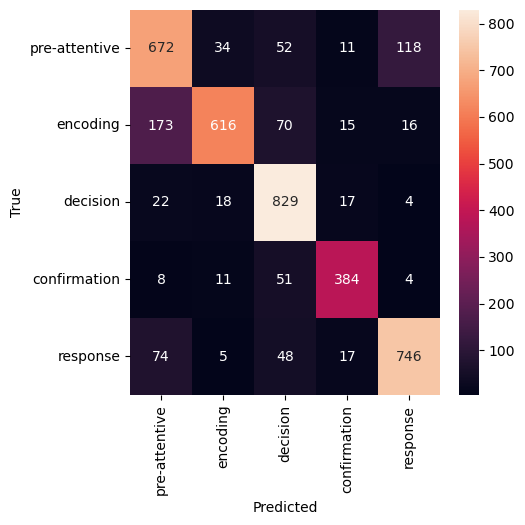

In [67]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)